<a href="https://colab.research.google.com/github/aaaksenova/ResearchSeminar_NN/blob/change/LSTM_attention_BERT_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Скачиваем данные

In [3]:
# Добавила сид
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
!wget https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv

--2021-12-19 06:54:46--  https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28717126 (27M) [text/plain]
Saving to: ‘answers_subsample.csv’

answers_subsample.c 100%[===================>]  27.39M   147MB/s    in 0.2s    

2021-12-19 06:54:47 (147 MB/s) - ‘answers_subsample.csv’ saved [28717126/28717126]



In [5]:
# если ругается на то, что нет wget
# !apt-get install wget

In [6]:
!ls -l

total 28052
-rw-r--r-- 1 root root 28717126 Dec 19 06:54 answers_subsample.csv
drwxr-xr-x 1 root root     4096 Dec  3 14:33 sample_data


In [7]:
import pandas as pd

In [8]:
data = pd.read_csv('answers_subsample.csv')

In [9]:
data

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон
...,...,...
237774,relax,елку нарядили? =)
237775,law,"Имеется переработка при 75% ставки, отгулы не ..."
237776,food,Попробовала варить рис с половиной кубика для ...
237777,food,Почему рекоменд... Почему рекомендуют есть фру...


In [10]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [11]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2021-12-19 06:54:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1.22G  16.1MB/s    in 79s     

2021-12-19 06:56:08 (15.7 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [12]:
!ls -l

total 4458144
-rw-r--r-- 1 root root   28717126 Dec 19 06:54 answers_subsample.csv
-rw-r--r-- 1 root root 4536408847 Jan 18  2019 cc.ru.300.vec
drwxr-xr-x 1 root root       4096 Dec  3 14:33 sample_data


In [13]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [14]:
# потом можете добавить свою предобработку

def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [15]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [00:02<00:00, 88114.09it/s]


In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


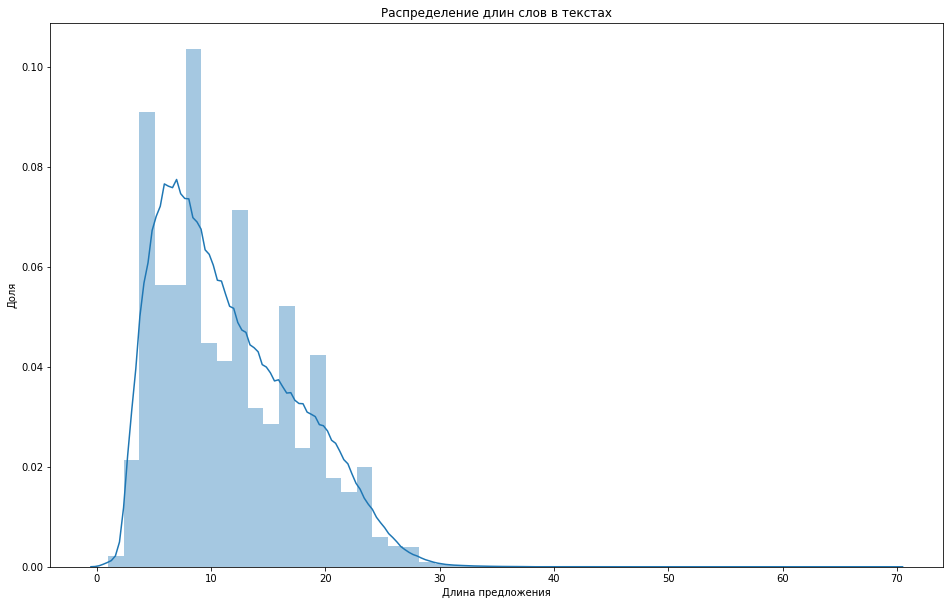

In [17]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [18]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.66 % наших текстов входят в промежуток от 3 до 32 слов'

In [19]:
len(word2freq)

152179

In [20]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'114332 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [21]:
import numpy as np

In [22]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:19<00:00, 25259.95it/s]


In [23]:
len(word2index)

117619

In [24]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 2.50 % слов в датасете
Количество неизвестных слов 34561 из 152179, то есть 22.71 % уникальных слов в словаре
В среднем каждое встречается 1.98 раз

Топ 5 невошедших слов:
??? с количеством вхождениий - 3641
?? с количеством вхождениий - 2448
!!! с количеством вхождениий - 2214
?) с количеством вхождениий - 2069
"? с количеством вхождениий - 1429


# Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой.

In [25]:
import torch

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [26]:
x = torch.rand(128, 64, 1024)

In [27]:
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

In [28]:
%%timeit

pred = lstm(x)

1 loop, best of 5: 823 ms per loop


# А что GPU?

In [29]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
print('Если недоступна, поменяйте runtime, если в колабе')

Доступна ли видеокарта: True
Если недоступна, поменяйте runtime, если в колабе


In [30]:
# универсальных способ задать device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# если доступна gpu, то давайте ее использовать, но в этом задании должны использовать

In [31]:
# перенесли x на gpu
x_gpu = x.to(device)

In [32]:
# зададим lstm на gpu
lstm_gpu = torch.nn.LSTM(1024, 512, batch_first=True)
lstm_gpu = lstm_gpu.to(device)

In [33]:
%%timeit

pred = lstm_gpu(x_gpu)

100 loops, best of 5: 27.6 ms per loop


# У меня на 1070 TI скорость уменьшилась с 381мс до 41мс, то есть в 9.29 раз

In [34]:
# если у нас модель на гпу, а то, что мы туда подаем нет, то работать не будет
# справедлива и обратная ситуация

# выскочит ошибка
# посмотрите на нее, возможно, вы еще встретитесь
# pred = lstm_gpu(x)

# Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [35]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

pred, mem = lstm(x)

In [36]:
pred.shape

torch.Size([128, 64, 512])

In [37]:
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [38]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

torch.Size([64, 128, 512])

In [39]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

torch.Size([128, 64, 512])

## Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [40]:
x.shape

torch.Size([128, 64, 1024])

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [41]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [42]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [43]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

torch.Size([128, 1024, 64])

In [44]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

torch.Size([128, 512, 62])

In [45]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

torch.Size([128, 62, 512])

# Подготовим данные в DataLoader

In [46]:
from torch.utils.data import Dataset, DataLoader

In [47]:
'UNK' in word2index

False

In [48]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


# Замапим категории в индексы

In [49]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [50]:
cat_mapper

{'business': 0, 'food': 4, 'law': 1, 'love': 2, 'relax': 3}

In [51]:
data.category = data.category.map(cat_mapper)

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
    1. Паддим до нужной длины
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.


In [52]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки
        
        words = wordpunct_tokenize(text.lower())
        #words = re.findall('[a-яА-ЯеЁ]+', text.lower())
        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:
            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        return [self.word2index[word] for word in tokenized_text if word in self.word2index]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        if len(sequence)< self.sequence_length:
          add_pad = self.sequence_length - len(sequence)
          return sequence+[self.pad_index]*add_pad
        else:
          return sequence[:self.sequence_length]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [54]:
x_train, x_validation, y_train, y_validation = train_test_split(data.text, data.category, test_size=0.1)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_validation), list(y_validation), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)

Loading data: 100%|██████████| 23778/23778 [00:00<00:00, 73906.33it/s]


In [55]:
for x, y in train_loader:
    break

In [56]:
x

tensor([[  115,    56,   160,  ...,     0,     0,     0],
        [   46, 27846,    41,  ...,     0,     0,     0],
        [97006, 35191,    14,  ...,     0,     0,     0],
        ...,
        [   24,   152, 64214,  ...,     0,     0,     0],
        [ 9867,    21,  5438,  ...,     0,     0,     0],
        [ 5229,   695,    10,  ...,     0,     0,     0]])

In [57]:
y

tensor([3, 1, 4, 2, 3, 2, 0, 4, 4, 2, 3, 1, 3, 1, 3, 3, 3, 0, 1, 3, 0, 4, 3, 0,
        0, 1, 0, 1, 2, 1, 1, 4, 0, 3, 1, 0, 2, 1, 1, 4, 1, 2, 1, 0, 1, 0, 1, 3,
        4, 2, 1, 2, 0, 1, 1, 1, 1, 1, 4, 3, 0, 3, 4, 3])

# Обучить нейронку

In [58]:
from math import sqrt

class model_with_att(torch.nn.Module):
      def __init__(self, matrix_w, n): #n - количетсво категорий

            super().__init__()

            self.n = n

            self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))

            self.LSTM = torch.nn.LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
            # задайте лстм, можно 2 уровня, лучше бидирекциональный, в доке торча есть инофрмация как это сделать в одну строчку

            self.q_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True) # три линейных преобразования, размерность совпадает с выходом из лстм (если БИлстм то надо умножить ее на 2)
            self.k_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
            self.v_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)

            self.att_soft = torch.nn.Softmax(dim = 2)

            self.cnn_3gr = torch.nn.Conv1d(256, 128, kernel_size=(3,), stride=(1,)) # три конволюционных фильтра с разными ядрами (3,4,5) чтобы были всякие нграммы ловить
            self.cnn_4gr = torch.nn.Conv1d(256, 128, kernel_size=(4,), stride=(1,))
            self.cnn_5gr = torch.nn.Conv1d(256, 128, kernel_size=(5,), stride=(1,))

            self.linear_1 = torch.nn.Linear(in_features=384, out_features=256, bias=True) # сверху накидываем два полносвязных слоя для классификации
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(in_features=256, out_features=5, bias=True)


      def forward(self, x):
          x_emb = self.emb_layer(x) #примените эмбеддинги 
          # транспонируйте тензор для лстм как было описано выше
          x_lstm, _ = self.LSTM(x_emb) # применим лстм, не забываем что на выходе у него много всяких последовательностей, нам нужна только эта

          x_q = self.q_proj(x_lstm) # применим линейные преобразования для селф-эттеншена
          x_k = self.k_proj(x_lstm)
          x_v = self.v_proj(x_lstm)

          att_scores = torch.bmm(x_q, x_k.transpose(2, 1)) /  math.sqrt(x_q.size(-1))
          # посмотрите в презентацию и перемножьте нужные тензора изспольуя функцию bmm из торча, перед этим одну из матриц обзательно транспонируйте
          # результат обязательно поделите на корень из последней размерности (то есть на рземер эмбеддинга из предыдущего слоя)
          att_dist = self.att_soft(att_scores) # накидываем софтмакс
          attention_vectors = torch.bmm(att_dist, x_v) # тут тоже что то с чем то нужно перемножить :)

          x_att = attention_vectors.transpose(2, 1) #транспонируем для конфолючионнах фильтров

          x_cnn3 = self.cnn_3gr(x_att)
          x_cnn4 = self.cnn_4gr(x_att)
          x_cnn5 = self.cnn_5gr(x_att)

          frst, _ =  x_cnn3.max(dim= -1,) # cделаем макс пуллинг
          sc, _ = x_cnn4.max(dim= -1,)
          thr, _ = x_cnn5.max(dim= -1,)

          x_cat = torch.cat((frst, sc, thr), dim=-1) # а теперь объединим результаты

          x = self.linear_1(x_cat) # пару полносвязных слоев с релу для классификации
          x = self.relu(x)    
          x = self.linear_2(x)

          return x

In [59]:
n_classes = data.category.unique().shape[0]
model = model_with_att(vectors, n_classes)

In [60]:
model #если сделать batch_first=True, то можно не транспонировать батчи

model_with_att(
  (emb_layer): Embedding(117619, 300)
  (LSTM): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (q_proj): Linear(in_features=512, out_features=256, bias=True)
  (k_proj): Linear(in_features=512, out_features=256, bias=True)
  (v_proj): Linear(in_features=512, out_features=256, bias=True)
  (att_soft): Softmax(dim=2)
  (cnn_3gr): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (cnn_4gr): Conv1d(256, 128, kernel_size=(4,), stride=(1,))
  (cnn_5gr): Conv1d(256, 128, kernel_size=(5,), stride=(1,))
  (linear_1): Linear(in_features=384, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=5, bias=True)
)

In [62]:
import math

In [63]:
with torch.no_grad():
    pred = model(x)

In [64]:
pred.shape

torch.Size([64, 5])

In [65]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [66]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [67]:
set_random_seed(42)

epochs = 10
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 test - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1: 100%|██████████| 214001/214001 [03:27<00:00, 1029.74it/s, train_loss=0.476]



Losses: train - 0.565, test - 0.466
F1 test - 0.832


Epoch 2: 100%|██████████| 214001/214001 [03:26<00:00, 1036.70it/s, train_loss=0.441]



Losses: train - 0.452, test - 0.447
F1 test - 0.838


Epoch 3: 100%|██████████| 214001/214001 [03:26<00:00, 1038.60it/s, train_loss=0.417]



Losses: train - 0.426, test - 0.439
F1 test - 0.842


Epoch 4: 100%|██████████| 214001/214001 [03:26<00:00, 1037.19it/s, train_loss=0.395]



Losses: train - 0.403, test - 0.442
F1 test - 0.842
Early stopping


Если вы запускаете много раз колаб окна и ткдм начинает беситься, можно запустить окно ниже, ткдм обновится и все снова станет хорошо

# Оценка
1. Добрались сюда - очень хорошо - получилась такая же точность или около того - 7 баллов. ✅
2. Поставили эксперименты и повысили точность относительно своей и не ниже F1 test - 0.841 - 8 баллов.
3. Запустили бертовую тетрадку и разобрались. Получился сравнимый результат - 10 баллов 

Какие эксперименты я ставила:

1. Weight decay в Адаме – не улучшило
2. Больше линейных слоев и дропаута – вообще перестало нормально учиться
3. Стала менять функцию активации на что-то более фэнси: пробовала LeakyReLU, SiLU, остановилась на Parametric ReLU, она и решила задачку с улучшением качества


In [68]:
class model_upd(torch.nn.Module):
      def __init__(self, matrix_w, n): #n - количетсво категорий

            super().__init__()

            self.n = n

            self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))

            self.LSTM = torch.nn.LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
            # задайте лстм, можно 2 уровня, лучше бидирекциональный, в доке торча есть инофрмация как это сделать в одну строчку

            self.q_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True) # три линейных преобразования, размерность совпадает с выходом из лстм (если БИлстм то надо умножить ее на 2)
            self.k_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
            self.v_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)

            self.att_soft = torch.nn.Softmax(dim = 2)

            self.cnn_3gr = torch.nn.Conv1d(256, 128, kernel_size=(3,), stride=(1,)) # три конволюционных фильтра с разными ядрами (3,4,5) чтобы были всякие нграммы ловить
            self.cnn_4gr = torch.nn.Conv1d(256, 128, kernel_size=(4,), stride=(1,))
            self.cnn_5gr = torch.nn.Conv1d(256, 128, kernel_size=(5,), stride=(1,))

            self.linear_1 = torch.nn.Linear(in_features=384, out_features=256, bias=True) # сверху накидываем два полносвязных слоя для классификации
            self.linear_added = torch.nn.Linear(in_features=256, out_features=256, bias=True) 
            self.relu = torch.nn.PReLU()
            self.dropout = torch.nn.Dropout(p=0.5)
            self.linear_2 = torch.nn.Linear(in_features=256, out_features=5, bias=True)


      def forward(self, x):
          x_emb = self.emb_layer(x) #примените эмбеддинги 
          # транспонируйте тензор для лстм как было описано выше
          x_lstm, _ = self.LSTM(x_emb) # применим лстм, не забываем что на выходе у него много всяких последовательностей, нам нужна только эта

          x_q = self.q_proj(x_lstm) # применим линейные преобразования для селф-эттеншена
          x_k = self.k_proj(x_lstm)
          x_v = self.v_proj(x_lstm)

          att_scores = torch.bmm(x_q, x_k.transpose(2, 1)) /  math.sqrt(x_q.size(-1))
          # посмотрите в презентацию и перемножьте нужные тензора изспольуя функцию bmm из торча, перед этим одну из матриц обзательно транспонируйте
          # результат обязательно поделите на корень из последней размерности (то есть на рземер эмбеддинга из предыдущего слоя)
          att_dist = self.att_soft(att_scores) # накидываем софтмакс
          attention_vectors = torch.bmm(att_dist, x_v) # тут тоже что то с чем то нужно перемножить :)

          x_att = attention_vectors.transpose(2, 1) #транспонируем для конфолючионнах фильтров

          x_cnn3 = self.cnn_3gr(x_att)
          x_cnn4 = self.cnn_4gr(x_att)
          x_cnn5 = self.cnn_5gr(x_att)

          frst, _ =  x_cnn3.max(dim= -1,) # cделаем макс пуллинг
          sc, _ = x_cnn4.max(dim= -1,)
          thr, _ = x_cnn5.max(dim= -1,)

          x_cat = torch.cat((frst, sc, thr), dim=-1) # а теперь объединим результаты

          x = self.linear_1(x_cat) # пару полносвязных слоев с релу для классификации
          x = self.dropout(self.relu(x))      
          x = self.linear_2(x)

          return x

In [69]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

In [70]:
n_classes = data.category.unique().shape[0]
model = model_upd(vectors, n_classes)

In [71]:
set_random_seed(42)
model = model_upd(vectors, n_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters()) #, weight_decay=0.0001)

model = model.to(device)
criterion = criterion.to(device)

In [72]:
set_random_seed(42)
epochs = 10
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 test - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1: 100%|██████████| 214001/214001 [03:24<00:00, 1045.30it/s, train_loss=0.487]



Losses: train - 0.588, test - 0.462
F1 test - 0.833


Epoch 2: 100%|██████████| 214001/214001 [03:22<00:00, 1057.10it/s, train_loss=0.448]



Losses: train - 0.460, test - 0.444
F1 test - 0.838


Epoch 3: 100%|██████████| 214001/214001 [03:21<00:00, 1060.47it/s, train_loss=0.424]



Losses: train - 0.433, test - 0.443
F1 test - 0.840


Epoch 4: 100%|██████████| 214001/214001 [03:22<00:00, 1054.73it/s, train_loss=0.403]



Losses: train - 0.411, test - 0.442
F1 test - 0.841


Epoch 5: 100%|██████████| 214001/214001 [03:22<00:00, 1059.29it/s, train_loss=0.382]



Losses: train - 0.391, test - 0.456
F1 test - 0.839
Early stopping


In [73]:
from torch.optim.lr_scheduler import ExponentialLR

In [74]:
set_random_seed(42)
n_classes = data.category.unique().shape[0]
model = model_upd(vectors, n_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters()) #, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.7)

model = model.to(device)
criterion = criterion.to(device)

In [75]:
set_random_seed(42)
epochs = 10
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])

    scheduler.step()    
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 test - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 1: 100%|██████████| 214001/214001 [03:24<00:00, 1046.02it/s, train_loss=0.486]



Losses: train - 0.588, test - 0.471
F1 test - 0.830


Epoch 2: 100%|██████████| 214001/214001 [03:24<00:00, 1048.91it/s, train_loss=0.444]



Losses: train - 0.454, test - 0.453
F1 test - 0.837


Epoch 3: 100%|██████████| 214001/214001 [03:24<00:00, 1044.82it/s, train_loss=0.416]



Losses: train - 0.426, test - 0.440
F1 test - 0.840


Epoch 4: 100%|██████████| 214001/214001 [03:25<00:00, 1043.74it/s, train_loss=0.395]



Losses: train - 0.405, test - 0.433
F1 test - 0.842


Epoch 5: 100%|██████████| 214001/214001 [03:25<00:00, 1043.03it/s, train_loss=0.376]



Losses: train - 0.388, test - 0.434
F1 test - 0.843
Early stopping


# BERT

In [ ]:
! pip install transformers

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
sentences = data.text.values
labels = data.category.values

In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста
Tokenized:  ['могут', 'ли', 'в', 'рос', '##сель', '##хо', '##з', '##бан', '##ке', 'да', '##ть', 'в', 'зал', '##ог', 'но', '##рк', '##овых', 'ш', '##уб', 'пом', '##оги', '##те', 'по', '##жал', '##уи', '##ста']
Token IDs:  [22553, 23029, 309, 26673, 80686, 37489, 11637, 42572, 11827, 10448, 11569, 309, 53932, 19820, 11299, 53464, 20565, 330, 58675, 86074, 60338, 10740, 10291, 28704, 62848, 15294]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста
Token IDs: [101, 22553, 23029, 309, 26673, 80686, 37489, 11637, 42572, 11827, 10448, 11569, 309, 53932, 19820, 11299, 53464, 20565, 330, 58675, 86074, 60338, 10740, 10291, 28704, 62848, 15294, 102]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  97


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# Let's set max_len to 97
MAX_LEN = 97

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 97 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 64

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(data.category.unique()), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Проверяем что по параметрам все как в исходной тетрадке

In [ ]:
b = model.bert.pooler.dense.weight
c = model.classifier.weight
b = b.cpu().detach().numpy()
c = c.cpu().detach().numpy()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

Все как надо: в оригинале 28 классов, у нас 5

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 100, # Default value in run_glue.py
                                            num_training_steps = total_steps)

В оригинале считают accuracy, я переопределю функцию под F1

In [ ]:
import numpy as np

# Function to calculate f1 score of our predictions vs labels
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average='micro')

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
set_random_seed(42)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_f1 = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate f1 score for this batch of test sentences.
        tmp_eval_f1 = flat_f1(logits, label_ids)
        
        # Accumulate the total f1 score.
        eval_f1 += tmp_eval_f1

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final F1 score for this validation run.
    print("  F1 score: {0:.2f}".format(eval_f1/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  3,344.    Elapsed: 0:00:23.
  Batch    80  of  3,344.    Elapsed: 0:00:46.
  Batch   120  of  3,344.    Elapsed: 0:01:10.
  Batch   160  of  3,344.    Elapsed: 0:01:33.
  Batch   200  of  3,344.    Elapsed: 0:01:56.
  Batch   240  of  3,344.    Elapsed: 0:02:20.
  Batch   280  of  3,344.    Elapsed: 0:02:43.
  Batch   320  of  3,344.    Elapsed: 0:03:07.
  Batch   360  of  3,344.    Elapsed: 0:03:30.
  Batch   400  of  3,344.    Elapsed: 0:03:53.
  Batch   440  of  3,344.    Elapsed: 0:04:16.
  Batch   480  of  3,344.    Elapsed: 0:04:40.
  Batch   520  of  3,344.    Elapsed: 0:05:03.
  Batch   560  of  3,344.    Elapsed: 0:05:27.
  Batch   600  of  3,344.    Elapsed: 0:05:50.
  Batch   640  of  3,344.    Elapsed: 0:06:13.
  Batch   680  of  3,344.    Elapsed: 0:06:37.
  Batch   720  of  3,344.    Elapsed: 0:07:00.
  Batch   760  of  3,344.    Elapsed: 0:07:23.
  Batch   800  of  3,344.    Elapsed: 0:07:46.
  Batch   840  of